In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style(grid=False)

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# set figure size
plt.rcParams["figure.figsize"] = (10,8)
# specify decimal places to display
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from wrangle import wrangle_manila

In [2]:
df = wrangle_manila()
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year,decade
dt,,,,,,,,,
1845-01-01,25.00,1.87,Manila,Philippines,15.27N,120.83E,1,1845,1840
1845-02-01,24.63,2.23,Manila,Philippines,15.27N,120.83E,2,1845,1840
1845-03-01,26.51,1.37,Manila,Philippines,15.27N,120.83E,3,1845,1840
1845-04-01,26.45,0.67,Manila,Philippines,15.27N,120.83E,4,1845,1840
1845-05-01,27.56,1.50,Manila,Philippines,15.27N,120.83E,5,1845,1840


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2025 entries, 1845-01-01 to 2013-09-01
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             2025 non-null   float64
 1   AverageTemperatureUncertainty  2025 non-null   float64
 2   City                           2025 non-null   object 
 3   Country                        2025 non-null   object 
 4   Latitude                       2025 non-null   object 
 5   Longitude                      2025 non-null   object 
 6   month                          2025 non-null   int64  
 7   year                           2025 non-null   int64  
 8   decade                         2025 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 158.2+ KB


In [4]:
manila = df.drop(columns=['City','Country','Latitude','Longitude'])
manila.head()

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1845-01-01,25.00,1.87,1,1845,1840
1845-02-01,24.63,2.23,2,1845,1840
1845-03-01,26.51,1.37,3,1845,1840
1845-04-01,26.45,0.67,4,1845,1840
1845-05-01,27.56,1.50,5,1845,1840


In [5]:
#168 years of data 1845-2013
manila.tail()

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
2013-05-01,29.55,0.25,5,2013,2010
2013-06-01,28.57,0.47,6,2013,2010
2013-07-01,27.27,0.60,7,2013,2010
2013-08-01,26.75,0.38,8,2013,2010
2013-09-01,26.45,0.67,9,2013,2010


# Split

In [6]:
# set train size to be 50% of total 
train_size = int(len(manila) * .5)
train_size

1012

In [7]:
# set validate size to be 30% of total 
validate_size = int(len(df) * .3)
validate_size

607

In [8]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

406

In [9]:
# validate will go from 1012 to 1012+607
validate_end_index = train_size + validate_size
validate_end_index

1619

In [10]:
# train will go from 0 to 1011
train = manila[: train_size]
# validate will go from 1012 to 1658
validate = manila[train_size:validate_end_index]
# test will include 1619 to the end
test = manila[validate_end_index:]

In [11]:
# is len of train + validate + test == length of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(manila))

True


In [12]:
#Does the first row of original df equate to the first row of train?
print(manila.head(1) == train.head(1))

            AverageTemperature  AverageTemperatureUncertainty  month  year  \
dt                                                                           
1845-01-01                True                           True   True  True   

            decade  
dt                  
1845-01-01    True  


In [13]:
#Is the last row of train the day before the first row of validate? And the same for validate to test?
pd.concat([train.tail(1), validate.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1929-04-01,27.88,0.33,4,1929,1920
1929-05-01,28.56,0.30,5,1929,1920


In [14]:
pd.concat([validate.tail(1), test.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1979-11-01,26.21,0.32,11,1979,1970
1979-12-01,24.61,0.31,12,1979,1970


In [15]:
#Is the last row of test the same as the last row of our original dataframe?
pd.concat([test.tail(1), manila.tail(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
2013-09-01,26.45,0.67,9,2013,2010
2013-09-01,26.45,0.67,9,2013,2010


In [16]:
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'month', 'year',
       'decade'],
      dtype='object')

In [17]:
temp_cols = ['AverageTemperature','AverageTemperatureUncertainty']

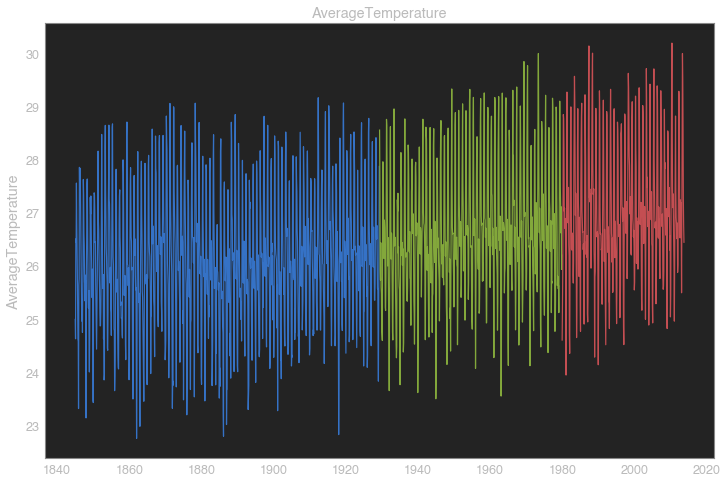

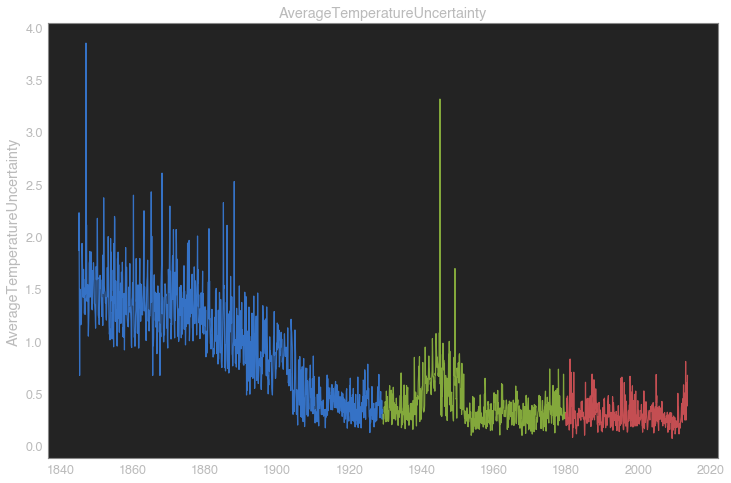

In [18]:
for col in train[temp_cols]:
    plt.figure(figsize=(12,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

array([[<AxesSubplot:title={'center':'AverageTemperature'}>,
        <AxesSubplot:title={'center':'AverageTemperatureUncertainty'}>]],
      dtype=object)

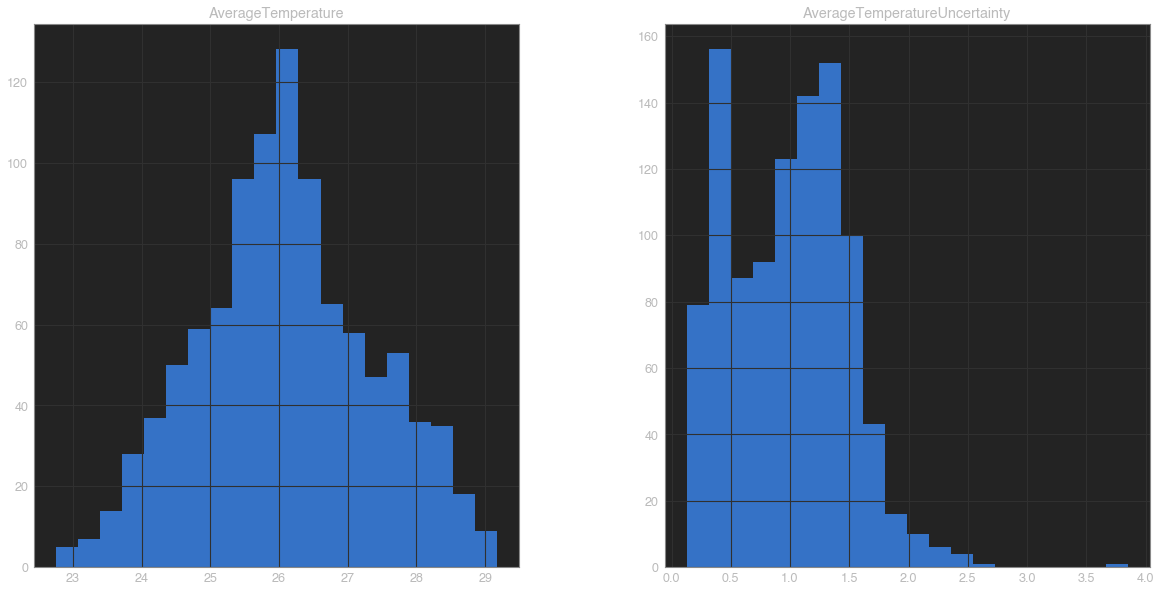

In [19]:
train[temp_cols].hist(bins=20,figsize=(20,10))

In [20]:
train.AverageTemperature.describe()

count   1012.00
mean      26.09
std        1.27
min       22.75
25%       25.26
50%       26.05
75%       26.93
max       29.17
Name: AverageTemperature, dtype: float64

<AxesSubplot:xlabel='month'>

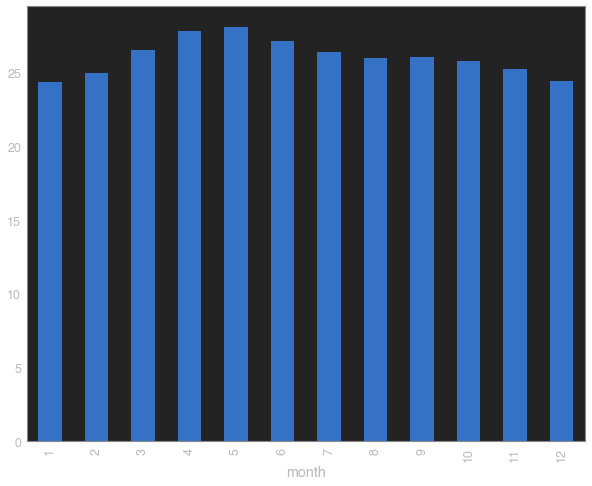

In [21]:
train.groupby('month').AverageTemperature.mean().plot.bar()

<AxesSubplot:xlabel='decade'>

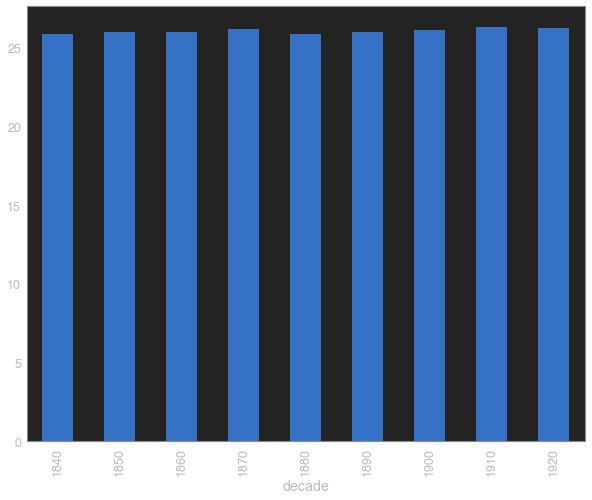

In [22]:
train.groupby('decade').AverageTemperature.mean().plot.bar()

<AxesSubplot:xlabel='month'>

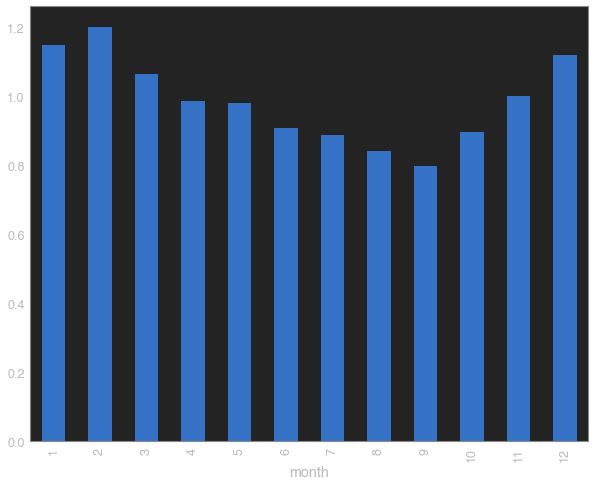

In [23]:
train.groupby('month').AverageTemperatureUncertainty.mean().plot.bar()

Text(6, 28, 'Rainy season June - November')

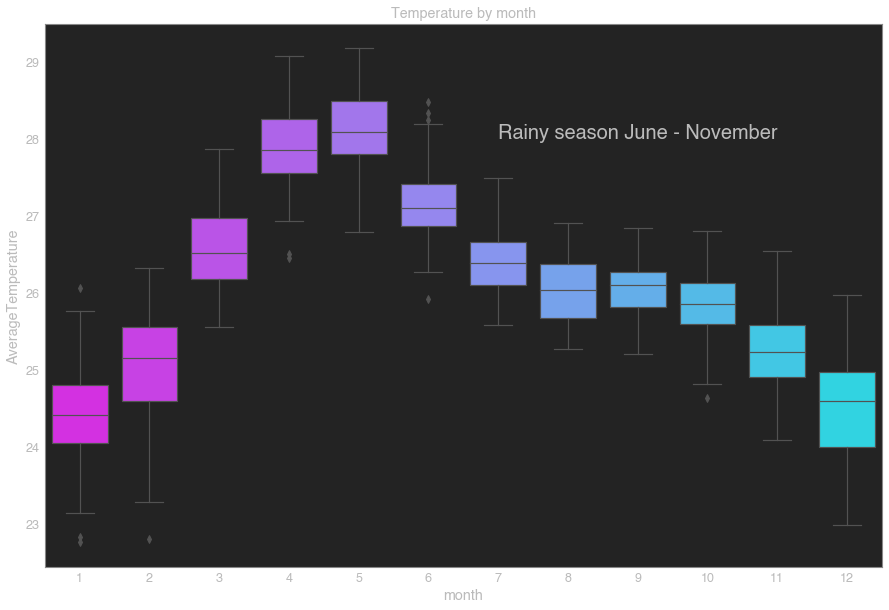

In [24]:
plt.figure(figsize=(15,10))
sns.boxplot(data = train, x='month', y='AverageTemperature', palette='cool_r')
plt.title('Temperature by month')
plt.annotate('Rainy season June - November', (6,28),fontsize=20)

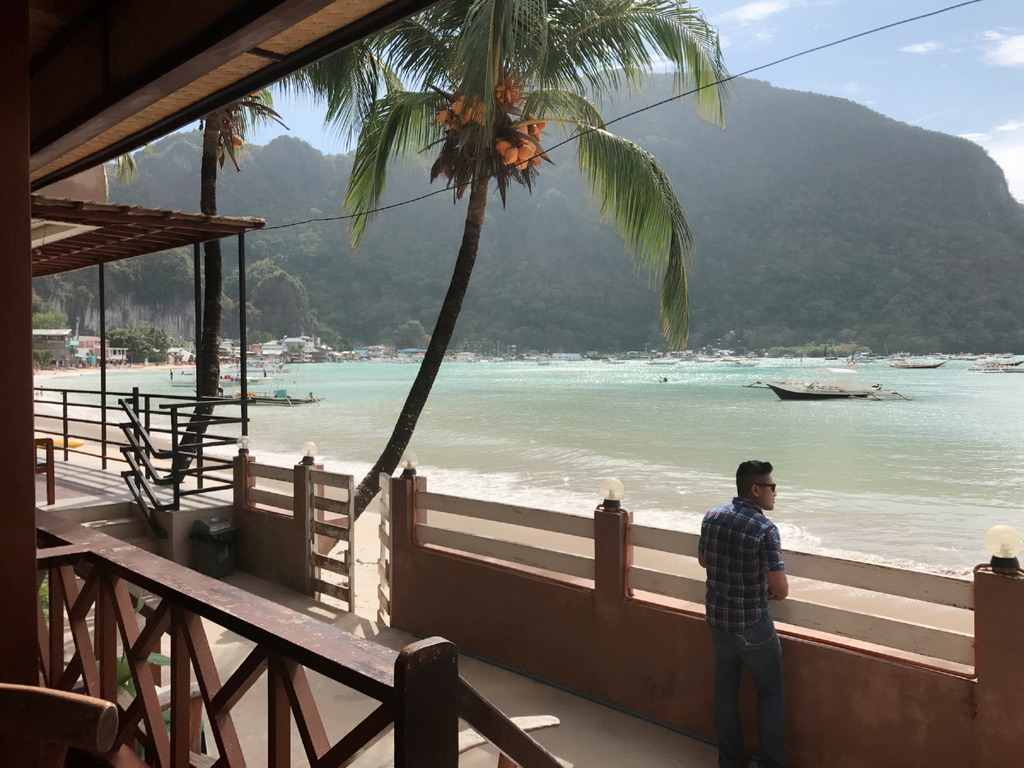

In [25]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "El_Nido.jpeg")

<AxesSubplot:xlabel='decade', ylabel='AverageTemperature'>

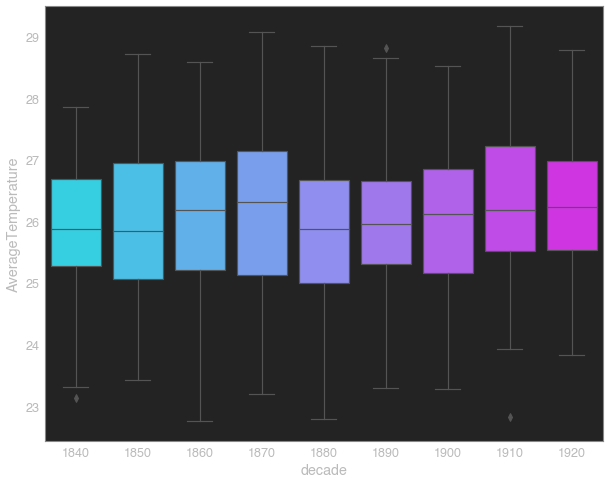

In [26]:
sns.boxplot(data = train, x='decade', y='AverageTemperature', palette='cool')

<AxesSubplot:xlabel='month', ylabel='AverageTemperatureUncertainty'>

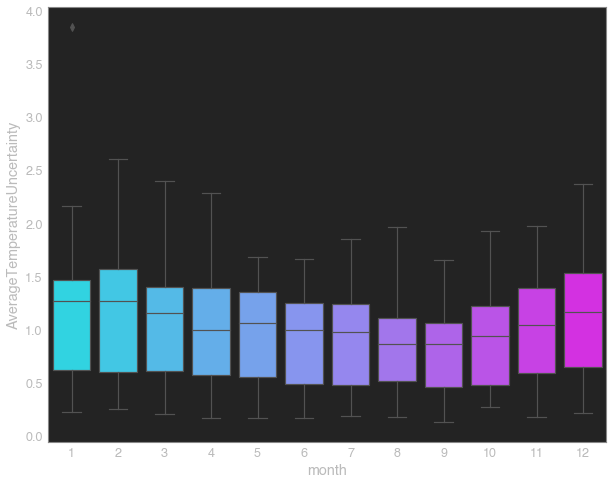

In [27]:
sns.boxplot(data = train, x='month', y='AverageTemperatureUncertainty', palette='cool')

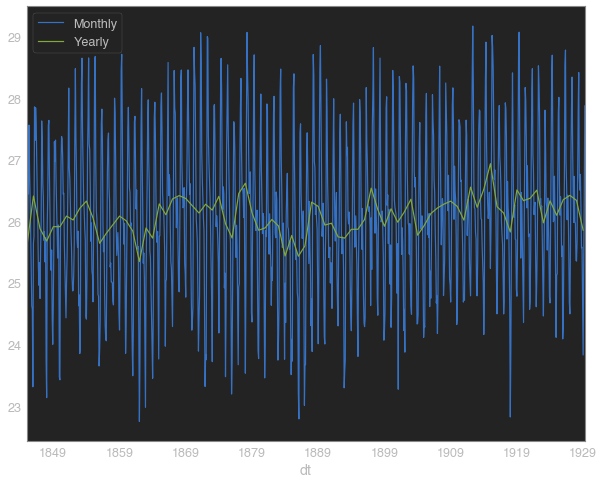

In [28]:
train.resample('M').mean().AverageTemperature.plot(label = 'Monthly')
train.resample('Y').mean().AverageTemperature.plot(label = 'Yearly')
plt.legend()

<AxesSubplot:xlabel='dt'>

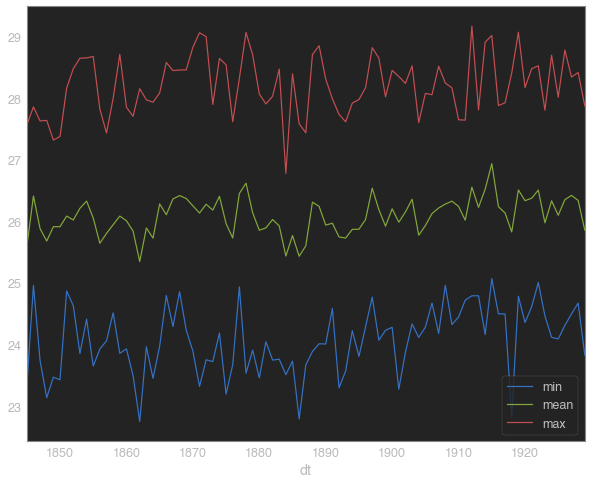

In [29]:
train.resample('Y').AverageTemperature.agg(['min','mean','max']).plot()

<AxesSubplot:xlabel='dt'>

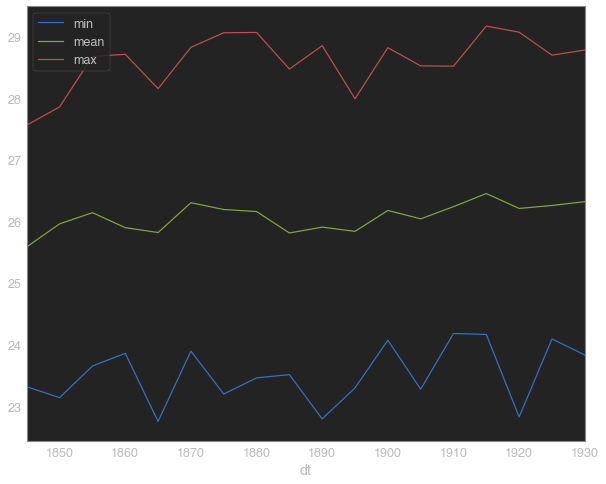

In [30]:
train.resample('5Y').AverageTemperature.agg(['min','mean','max']).plot()

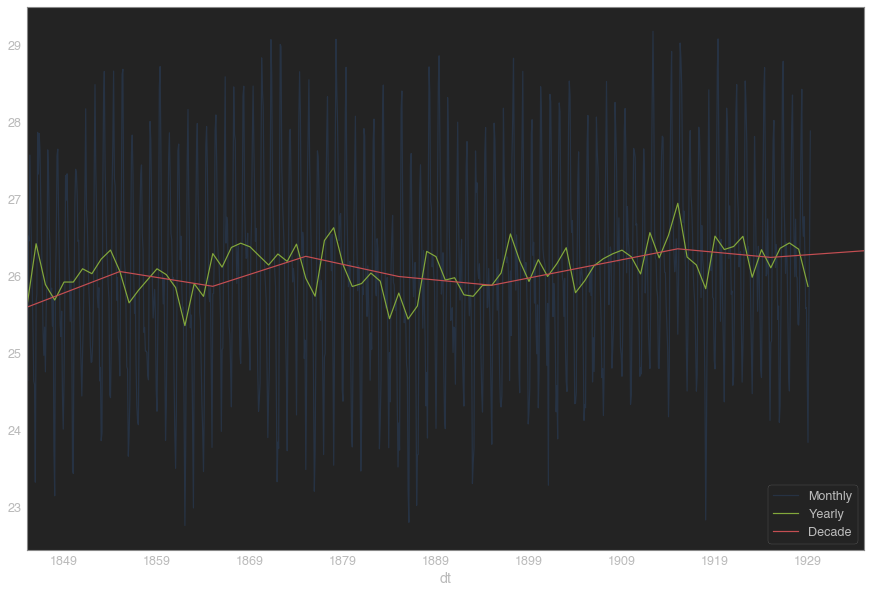

In [31]:
plt.figure(figsize=(15,10))
train.AverageTemperature.plot(alpha=.2, label='Monthly')
#train.resample('M').mean().AverageTemperature.plot(label='Monthly')
train.resample('Y').mean().AverageTemperature.plot(label='Yearly')
train.resample('10Y').mean().AverageTemperature.plot(label='Decade')
plt.legend()

<AxesSubplot:title={'center':'Average 5 year change in average temp'}, xlabel='dt'>

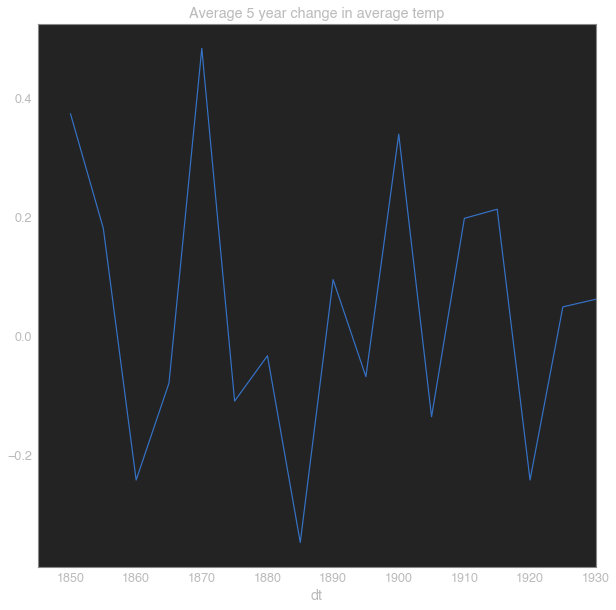

In [32]:
train.resample('5Y').AverageTemperature.mean().diff().plot(title = 'Average 5 year change in average temp', figsize = (10,10))

<AxesSubplot:xlabel='dt'>

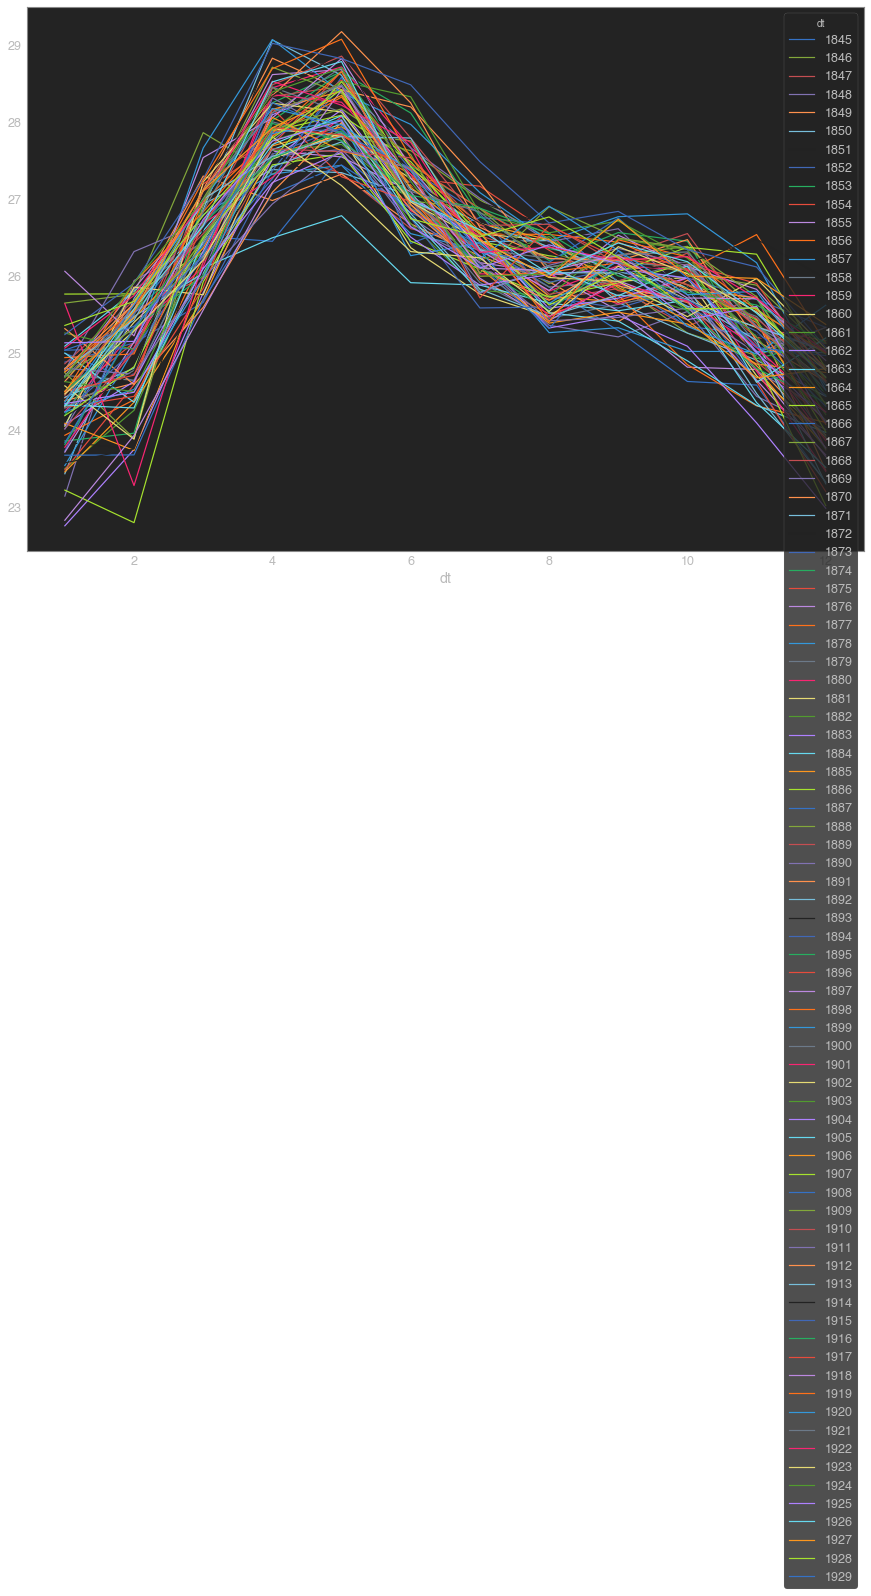

In [33]:
train.groupby([train.index.year, train.index.month]).AverageTemperature.mean().unstack(0).plot(figsize=(15,10))

In [34]:
table = train.groupby([train.index.year, train.index.month]).AverageTemperature.mean().unstack()
table

dt,1,2,3,4,5,6,7,8,9,10,11,12
dt,,,,,,,,,,,,
1845,25.00,24.63,26.51,26.45,27.56,26.82,26.41,25.86,25.29,24.63,24.58,23.32
1846,25.65,25.76,27.86,27.32,27.84,27.63,26.99,26.48,25.88,25.26,24.96,25.33
1847,24.75,25.55,25.98,27.63,27.33,26.61,26.39,25.69,25.84,25.34,25.74,23.74
1848,23.14,25.94,26.43,27.56,27.64,26.76,26.17,25.36,25.21,25.54,24.43,24.01
1849,24.63,25.64,27.30,26.98,27.32,26.68,26.26,25.92,25.41,25.94,25.44,23.47
1850,23.43,25.71,26.93,27.38,27.34,27.04,26.44,26.46,25.65,25.26,24.91,24.43
1851,25.01,25.42,26.26,27.03,28.16,26.86,26.69,26.23,25.84,25.57,25.09,24.87
1852,24.88,25.13,25.65,27.37,28.48,27.38,26.81,25.73,25.58,25.84,24.63,24.81
1853,23.86,23.96,26.99,28.25,28.65,27.43,26.88,26.35,26.18,25.88,25.70,24.45


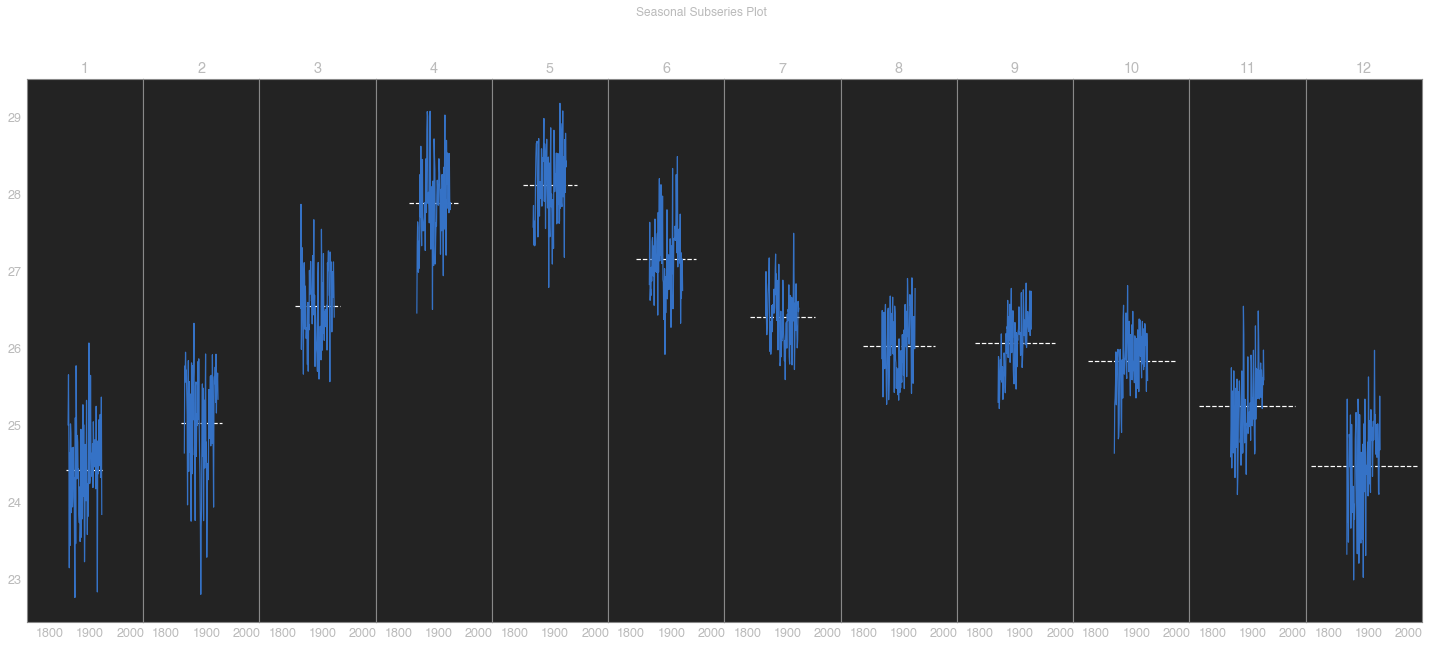

In [35]:
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month,figsize = (25,10))
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

In [36]:
y = train.AverageTemperature

Text(0.5, 1.0, 'Lag plot with lag = 1')

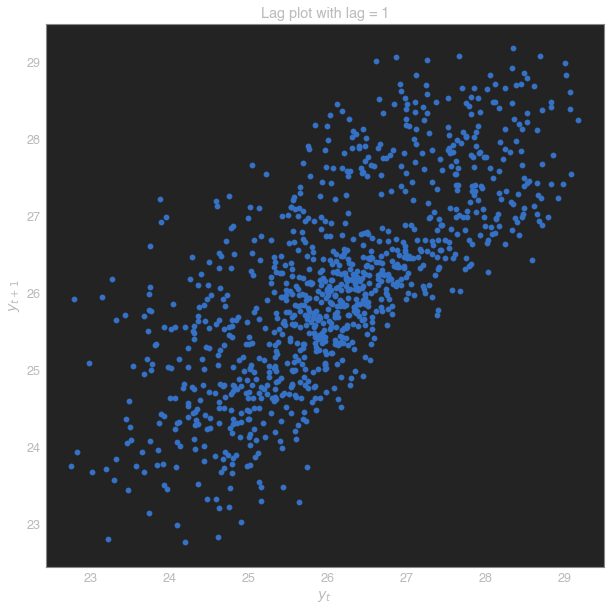

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(y, y.shift(-1))
plt.xlabel('$y_t$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag = 1')

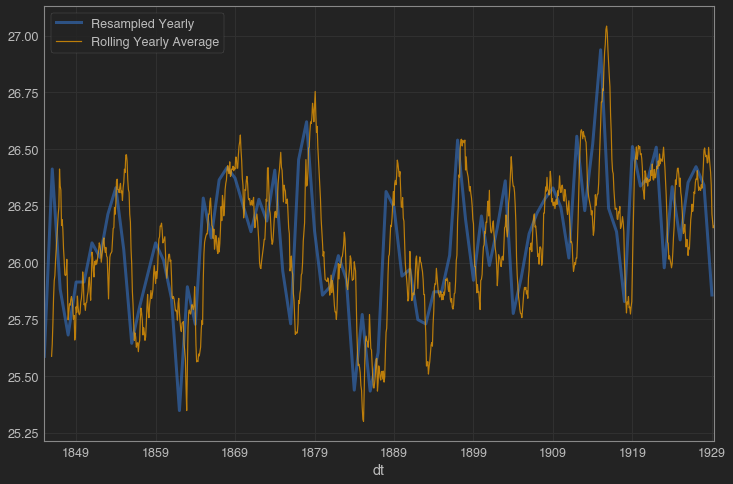

In [38]:
# Plot the weekly average & the 7-day moving average. Compare the 2 plots.
#plt.style.use('fivethirtyeight')
#plt.figure(figsize=(10,10))
jtplot.style(figsize=(15,10))
y.resample('Y').mean().plot(label='Resampled Yearly', alpha=.6, lw=3)
y.rolling(12).mean().plot(label='Rolling Yearly Average', alpha=0.7, color='orange')
plt.legend()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

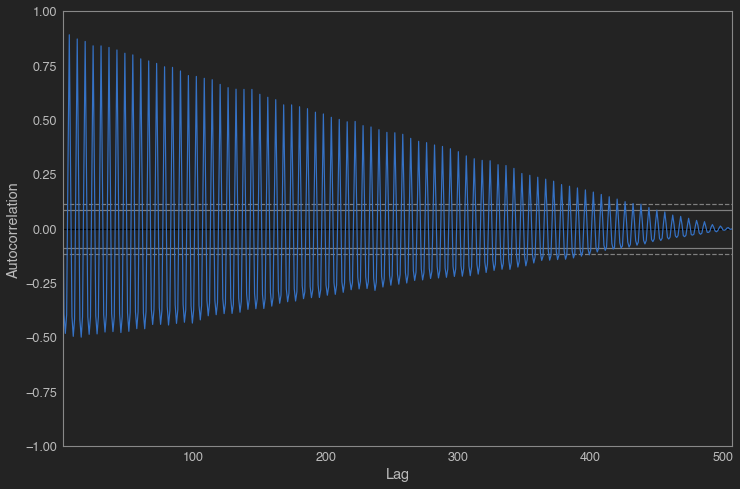

In [39]:
pd.plotting.autocorrelation_plot(train.AverageTemperature.resample('2M').mean())

In [40]:
y = train.AverageTemperature.resample('Y').mean()

result = sm.tsa.seasonal_decompose(y)
result

In [41]:
result.seasonal

dt
1845-12-31   0.00
1846-12-31   0.00
1847-12-31   0.00
1848-12-31   0.00
1849-12-31   0.00
1850-12-31   0.00
1851-12-31   0.00
1852-12-31   0.00
1853-12-31   0.00
1854-12-31   0.00
1855-12-31   0.00
1856-12-31   0.00
1857-12-31   0.00
1858-12-31   0.00
1859-12-31   0.00
1860-12-31   0.00
1861-12-31   0.00
1862-12-31   0.00
1863-12-31   0.00
1864-12-31   0.00
1865-12-31   0.00
1866-12-31   0.00
1867-12-31   0.00
1868-12-31   0.00
1869-12-31   0.00
1870-12-31   0.00
1871-12-31   0.00
1872-12-31   0.00
1873-12-31   0.00
1874-12-31   0.00
1875-12-31   0.00
1876-12-31   0.00
1877-12-31   0.00
1878-12-31   0.00
1879-12-31   0.00
1880-12-31   0.00
1881-12-31   0.00
1882-12-31   0.00
1883-12-31   0.00
1884-12-31   0.00
1885-12-31   0.00
1886-12-31   0.00
1887-12-31   0.00
1888-12-31   0.00
1889-12-31   0.00
1890-12-31   0.00
1891-12-31   0.00
1892-12-31   0.00
1893-12-31   0.00
1894-12-31   0.00
1895-12-31   0.00
1896-12-31   0.00
1897-12-31   0.00
1898-12-31   0.00
1899-12-31   0.00
1900-12

In [42]:
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
dt,,,,
1845-12-31,25.59,25.59,0.00,0.00
1846-12-31,26.41,26.41,0.00,0.00
1847-12-31,25.88,25.88,0.00,0.00
1848-12-31,25.68,25.68,0.00,0.00
1849-12-31,25.92,25.92,0.00,0.00


<AxesSubplot:xlabel='dt'>

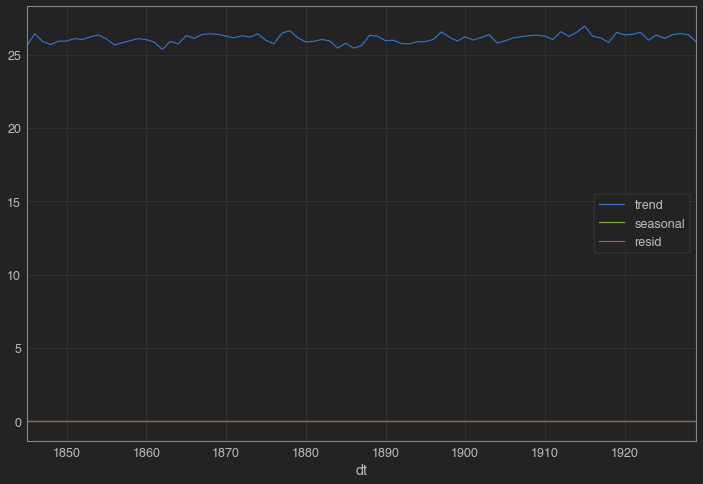

In [43]:
decomposition.iloc[:, 1:].plot()

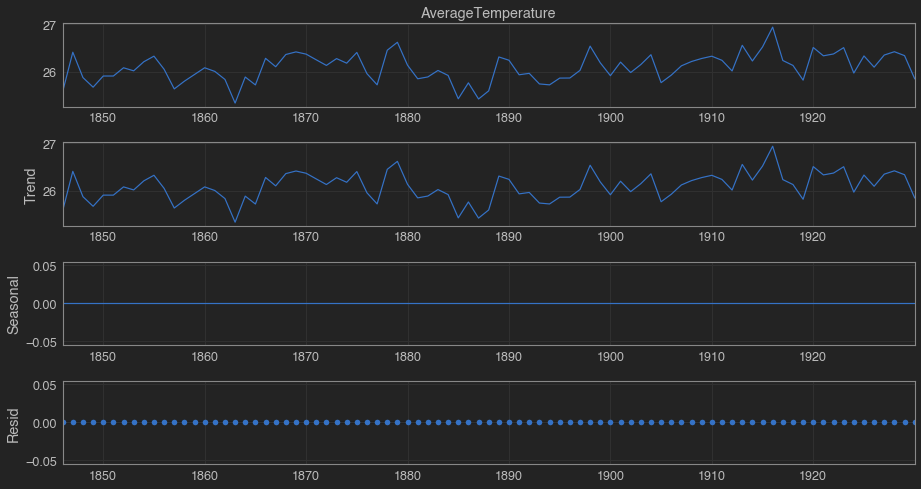

In [44]:
# the value returned from seasonal_decompose can itself be plotted:
plt.rc('figure', figsize=(13, 7))
result.plot()
None

In [45]:
# create a categorical feature
train['temp_bin'] = pd.qcut(train.AverageTemperature, 4, labels=['low', 'med_low', 'med_high', 'high'])
train.groupby('temp_bin').AverageTemperature.mean()

temp_bin
low        24.48
med_low    25.69
med_high   26.43
high       27.78
Name: AverageTemperature, dtype: float64

In [46]:
train.head()

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade,temp_bin
dt,,,,,,
1845-01-01,25.00,1.87,1,1845,1840,low
1845-02-01,24.63,2.23,2,1845,1840,low
1845-03-01,26.51,1.37,3,1845,1840,med_high
1845-04-01,26.45,0.67,4,1845,1840,med_high
1845-05-01,27.56,1.50,5,1845,1840,high


Text(0, 0.5, '% of days in the month')

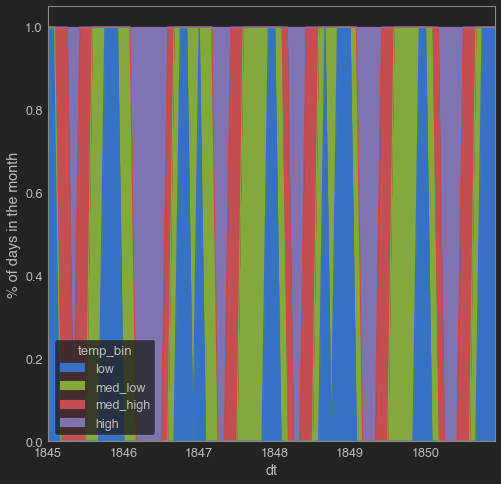

In [47]:
jtplot.style(grid=False,figsize=(10,10))
(train[:'1850'].groupby('temp_bin')
 .resample('M')
 .size() # like COUNT(*)
 .unstack(0) # turns an index level into columns
 .fillna(0)
 .astype(int)
 .apply(lambda row: row / row.sum(), axis=1) # raw nums to % of the row
 .plot.area()
)
plt.ylabel('% of days in the month')

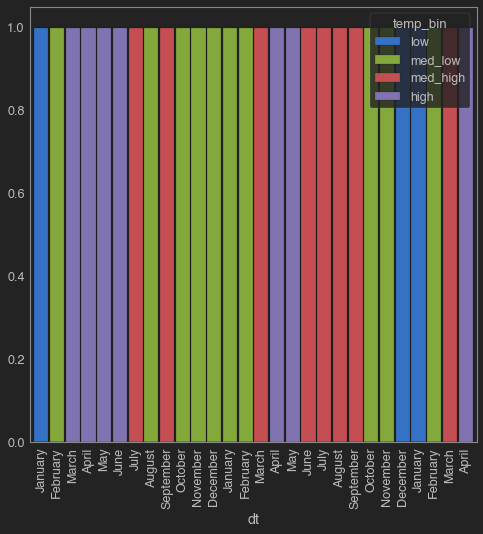

In [48]:
ax = (train['1927':'1929']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
# take the existing labels, convert them to Timestamps, and then reformat with .strftime
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels);

# Modeling

In [49]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [50]:
from evaluate import plot_and_eval, append_eval_df

### Last observed value (baseline)

In [51]:
temp = round(train['AverageTemperature'][-1:][0], 2)
temp

27.88

In [52]:
yhat_df = pd.DataFrame({'AverageTemperature': [temp]},index = validate.index)
yhat_df.head()

,AverageTemperature
dt,
1929-05-01,27.88
1929-06-01,27.88
1929-07-01,27.88
1929-08-01,27.88
1929-09-01,27.88


In [53]:
yhat_df.describe()

,AverageTemperature
count,607.00
mean,27.88
std,0.00
min,27.88
25%,27.88
50%,27.88
75%,27.88
max,27.88


AverageTemperature 2.0


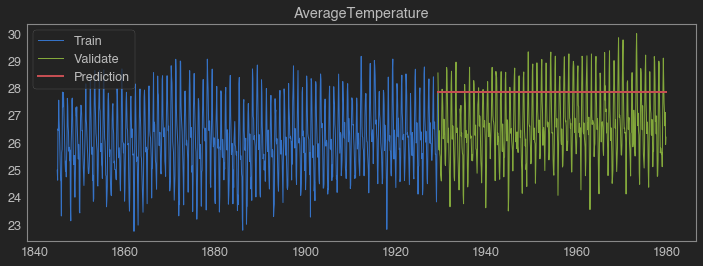

In [54]:
plot_and_eval(train,validate,yhat_df,'AverageTemperature')

In [55]:
eval_df = append_eval_df(validate,
                         eval_df,
                         yhat_df,
                         model_type='last_observed_value',
                         target_var='AverageTemperature')

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,2.00


### Simple Average

In [56]:
# compute simple average
temp = round(train['AverageTemperature'].mean(),2)
temp

26.09

In [57]:
def make_predictions():
    yhat_df = pd.DataFrame(
        {'AverageTemperature': [temp]},
        index=validate.index)
    return yhat_df


In [58]:
yhat_df = make_predictions()
yhat_df.head()

,AverageTemperature
dt,
1929-05-01,26.09
1929-06-01,26.09
1929-07-01,26.09
1929-08-01,26.09
1929-09-01,26.09


AverageTemperature 1.0


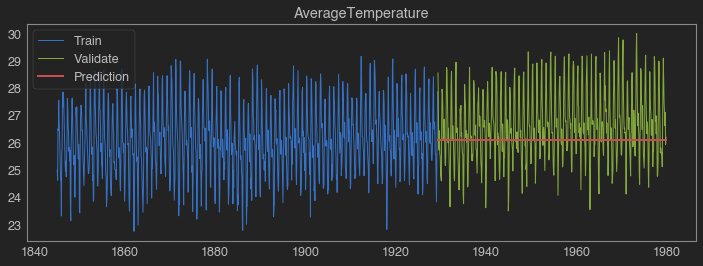

In [59]:
plot_and_eval(train,validate,yhat_df,'AverageTemperature')

In [60]:
eval_df = append_eval_df(validate,
                         eval_df,
                         yhat_df,
                         model_type='simple_average',
                         target_var='AverageTemperature')

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,2.00
1,simple_average,AverageTemperature,1.00


# Moving Average

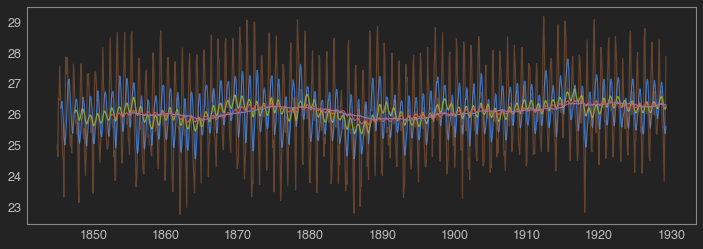

In [61]:
plt.figure(figsize=(12,4))
plt.plot(train['AverageTemperature'].rolling(7).mean())
plt.plot(train['AverageTemperature'].rolling(30).mean())
plt.plot(train['AverageTemperature'].rolling(90).mean())
plt.plot(train['AverageTemperature'].rolling(120).mean())
plt.plot(train['AverageTemperature'], alpha=.3)

In [62]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['AverageTemperature'].rolling(30).mean()[29])
print(train['AverageTemperature'].head(30).mean())

26.061944482929242
26.061944482929242


In [63]:
period = 24 

# take 24 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temp = round(train['AverageTemperature'].rolling(period).mean()[-1], 2)
print(temp)

26.31


In [64]:
yhat_df = make_predictions()
yhat_df.head()

,AverageTemperature
dt,
1929-05-01,26.31
1929-06-01,26.31
1929-07-01,26.31
1929-08-01,26.31
1929-09-01,26.31


AverageTemperature 1.0


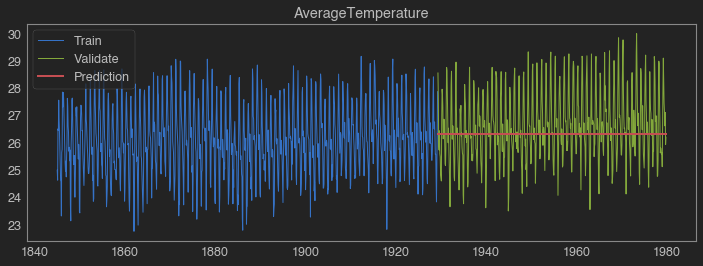

In [65]:
plot_and_eval(train,validate,yhat_df,'AverageTemperature')

In [66]:
eval_df = append_eval_df(validate,
                         eval_df,
                         yhat_df,
                         model_type='24m_moving_average',
                         target_var='AverageTemperature')

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,2.00
1,simple_average,AverageTemperature,1.00
2,24m_moving_average,AverageTemperature,1.00


# Previous Cycle

In [67]:
#Re-split data

train = manila['2008':'2010'][['AverageTemperature']]
validate = manila['2011'][['AverageTemperature']]
test = manila['2012'][['AverageTemperature']]

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(36, 1)
(12, 1)
(12, 1)


,AverageTemperature
dt,
2010-08-01,27.10
2010-09-01,27.36
2010-10-01,26.88
2010-11-01,26.55
2010-12-01,25.91


In [68]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2010'] + train.diff(12).mean()
yhat_df

,AverageTemperature
dt,
2010-01-01,25.73
2010-02-01,27.11
2010-03-01,28.50
2010-04-01,29.69
2010-05-01,30.48
2010-06-01,28.79
2010-07-01,27.74
2010-08-01,27.38
2010-09-01,27.64


In [69]:
train.loc['2010'].head()

,AverageTemperature
dt,
2010-01-01,25.45
2010-02-01,26.84
2010-03-01,28.23
2010-04-01,29.41
2010-05-01,30.20


In [70]:
# let's peek into the prediction we will make for 1/1/2011
# by comparing the predicted value 
# (2010 value + year-over-year average difference)
# to the actual 1/1/2010 value
pd.concat([yhat_df.head(1), validate.head(1)])

,AverageTemperature
dt,
2010-01-01,25.73
2011-01-01,24.96


In [71]:
# set yhat_df to index of validate

yhat_df.index = validate.index
yhat_df

,AverageTemperature
dt,
2011-01-01,25.73
2011-02-01,27.11
2011-03-01,28.50
2011-04-01,29.69
2011-05-01,30.48
2011-06-01,28.79
2011-07-01,27.74
2011-08-01,27.38
2011-09-01,27.64


In [72]:
yhat_df.describe()

,AverageTemperature
count,12.00
mean,27.77
std,1.39
min,25.73
25%,27.04
50%,27.51
75%,28.58
max,30.48


In [73]:
yhat_df.head()

,AverageTemperature
dt,
2011-01-01,25.73
2011-02-01,27.11
2011-03-01,28.50
2011-04-01,29.69
2011-05-01,30.48


In [74]:
yhat_df.shape

(12, 1)

AverageTemperature 1.0


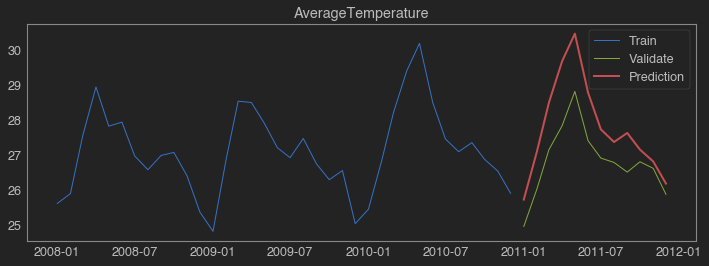

In [75]:
plot_and_eval(train,validate,yhat_df,'AverageTemperature')

In [76]:
eval_df = append_eval_df(validate,
                         eval_df,
                         yhat_df,
                         model_type='previous_year',
                         target_var='AverageTemperature')

eval_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,2.00
1,simple_average,AverageTemperature,1.00
2,24m_moving_average,AverageTemperature,1.00
3,previous_year,AverageTemperature,1.00
